# Sleep Health and Lifestyle Analysis

This notebook runs the full analysis pipeline using files in `Project-Details/` and the dataset at the project root. It will:

- Verify the environment and required packages
- Inspect `Project-Details/` and dataset files
- Load, clean, and explore the data
- Build simple preprocessing and modeling pipelines
- Export figures and a single `summary.md` for your PowerPoint

Run cells sequentially. The notebook saves outputs to `artifacts/` and `outputs/figures/` (created if missing).

In [1]:
# Section: Environment checks and imports
import sys
import platform
import os
import json
import math
from pathlib import Path

# Data and ML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Display settings
%matplotlib inline
sns.set(style='whitegrid')

print('Python:', sys.version.splitlines()[0])
print('Platform:', platform.platform())
print('Pandas:', pd.__version__)
print('NumPy:', np.__version__)
print('scikit-learn:', __import__('sklearn').__version__)

# Create artifacts folders
os.makedirs('artifacts', exist_ok=True)
os.makedirs('outputs/figures', exist_ok=True)

# Helper: project root
ROOT = Path('.').resolve()
print('Project root:', ROOT)

Python: 3.13.5 (v3.13.5:6cb20a219a8, Jun 11 2025, 12:23:45) [Clang 16.0.0 (clang-1600.0.26.6)]
Platform: macOS-15.7.1-arm64-arm-64bit-Mach-O
Pandas: 2.3.3
NumPy: 2.3.3
scikit-learn: 1.7.2
Project root: /Users/dustinober/Udacity/Sleep-Health-and-Lifestyle-Analysis


In [2]:
# Section: Inspect Project-Details folder
from pathlib import Path
import mimetypes

proj_details = ROOT / 'Project-Details'

file_rows = []
for p in proj_details.rglob('*'):
    try:
        size = p.stat().st_size
    except Exception:
        size = None
    mime, _ = mimetypes.guess_type(str(p))
    file_rows.append({'path': str(p.relative_to(ROOT)), 'is_dir': p.is_dir(), 'size': size, 'mime': mime})

pd.DataFrame(file_rows).sort_values(['is_dir','path']).head(100)

,path,is_dir,size,mime
2,Project-Details/dataset-overview.md,False,3150,text/markdown
1,Project-Details/presentation-components.md,False,1637,text/markdown
4,Project-Details/project-overview.md,False,1973,text/markdown
3,Project-Details/rubric.md,False,1942,text/markdown
0,Project-Details/tools-and-resources.md,False,1240,text/markdown


In [3]:
# Section: Locate CSVs at repo root and load main dataset
csv_files = list(ROOT.glob('*.csv'))
print('CSV files at repo root:')
for f in csv_files:
    print(' -', f.name)

# Try to locate the target CSV by name
target_name = 'sleep_health_and_lifestyle_dataset-sleep_health_and_lifestyle_dataset.csv'
if (ROOT / target_name).exists():
    csv_path = ROOT / target_name
elif csv_files:
    csv_path = csv_files[0]
    print('\nUsing first CSV found:', csv_path.name)
else:
    raise FileNotFoundError('No CSV found at project root')

print('\nLoading CSV:', csv_path)
df = pd.read_csv(csv_path)

print('\nShape:', df.shape)
print('\nDtypes:')
print(df.dtypes)

print('\nHead:')
display(df.head())

print('\nMissing values per column:')
print(df.isna().sum().sort_values(ascending=False).head(50))

# Save a small pickle for quick reload
(df.head(100)).to_pickle('artifacts/sample_head.pkl')

CSV files at repo root:
 - sleep_health_and_lifestyle_dataset-sleep_health_and_lifestyle_dataset.csv

Loading CSV: /Users/dustinober/Udacity/Sleep-Health-and-Lifestyle-Analysis/sleep_health_and_lifestyle_dataset-sleep_health_and_lifestyle_dataset.csv

Shape: (374, 13)

Dtypes:
Person ID                    int64
Gender                      object
Age                          int64
Occupation                  object
Sleep Duration             float64
Quality of Sleep             int64
Physical Activity Level      int64
Stress Level                 int64
BMI Category                object
Blood Pressure              object
Heart Rate                   int64
Daily Steps                  int64
Sleep Disorder              object
dtype: object

Head:


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea



Missing values per column:
Sleep Disorder             219
Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
dtype: int64


Numeric columns: ['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
Categorical columns: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']


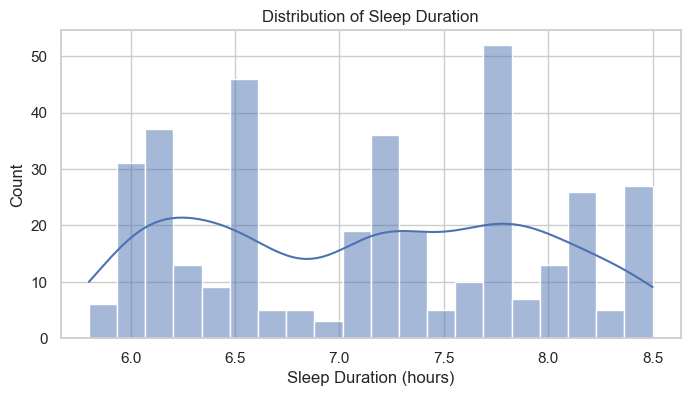

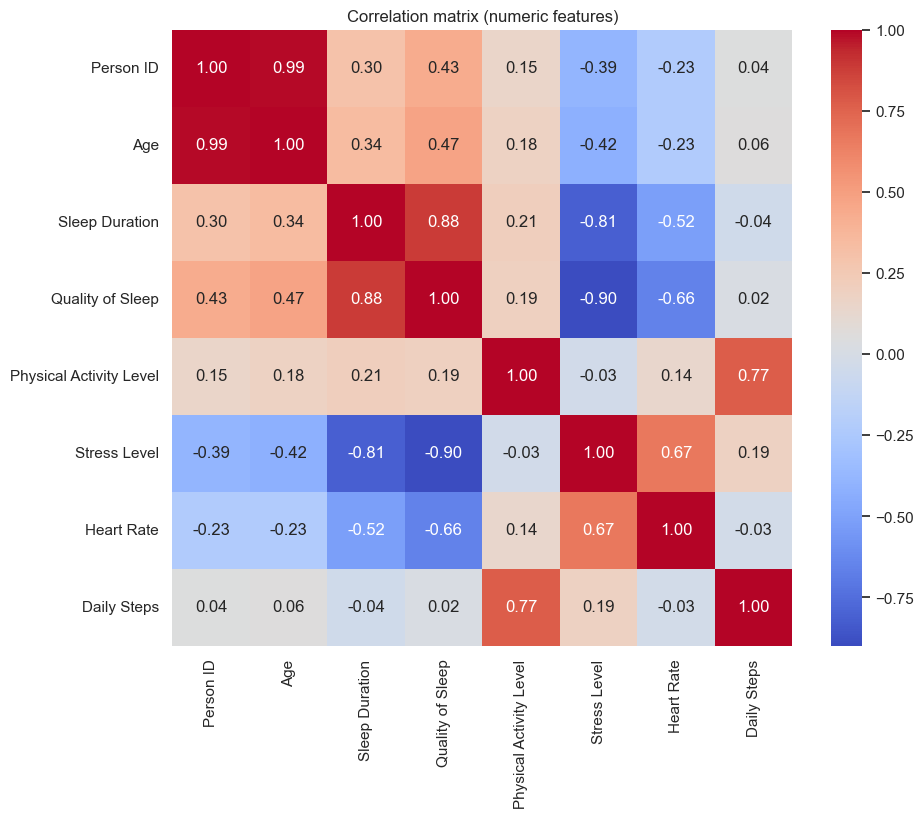

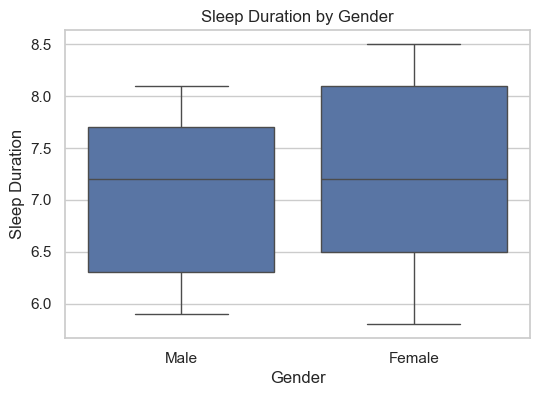

In [6]:
# Section: Basic EDA
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

print('Numeric columns:', numeric_cols)
print('Categorical columns:', cat_cols)

# Distribution of target: Sleep Duration
if 'Sleep Duration' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['Sleep Duration'].dropna(), bins=20, kde=True)
    plt.title('Distribution of Sleep Duration')
    plt.xlabel('Sleep Duration (hours)')
    plt.savefig('outputs/figures/sleep_duration_dist.png', dpi=150)
    plt.show()

# Correlation heatmap for numeric columns
plt.figure(figsize=(10,8))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (numeric features)')
plt.savefig('outputs/figures/correlation_matrix.png', dpi=150)
plt.show()

# Boxplot of Sleep Duration by Gender if available
if 'Gender' in df.columns and 'Sleep Duration' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Gender', y='Sleep Duration', data=df)
    plt.title('Sleep Duration by Gender')
    plt.savefig('outputs/figures/sleep_by_gender.png', dpi=150)
    plt.show()